# Scop3P

A comprehensive database of human phosphosites within their full context. Scop3P integrates sequences (UniProtKB/Swiss-Prot), structures (PDB), and uniformly reprocessed phosphoproteomics data (PRIDE) to annotate all known human phosphosites. 

Scop3P, available at https://iomics.ugent.be/scop3p, presents a unique resource for visualization and analysis of phosphosites and for understanding of phosphosite structure–function relationships.

## Install Dependencies

In [1]:
%%capture
!pip install bokeh pandas matplotlib b2btools==3.0.7b2

In [2]:
%%capture
import tempfile
import requests
import pandas as pd 
import py3Dmol
from b2bTools import SingleSeq, constants
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

ImportError: libtorch_cuda_cu.so: failed to map segment from shared object

## Target protein

In [3]:
TARGET_PROTEIN_ID = "O00571" # Write here the Protein ID of your protein of interest
PDB_ID = "4PXA" # Write here the PDB ID of your protein of interest

## API Request

This function makes a GET request to SCOP3P API endpoint for a given protein accession ID and returns the protein sequence in string format.

In [4]:
def fetch_sequence_aminoacids(accession):
    BASE_URL = f"http://uniprot.org/uniprotkb/{accession}.fasta"
    url = f'{BASE_URL}?accession={accession}'
    response = requests.get(url)
    if response.status_code == 200:
        raw_fasta_sequence = response.content.decode("utf-8")
    else:
        raw_fasta_sequence = ""
    
    lines = raw_fasta_sequence.split('\n')
    protein_id = str(lines[0])
    amino_acids = "".join([str(l) for l in lines[1:]])
    
    return protein_id, amino_acids

def fetch_protein_modifications(accession):
    """
    Fetches protein modifications for a given UniProt ID.

    Parameters:
    accession (str): UniProt ID of the protein.

    Returns:
    dict: A dictionary containing protein modifications.
    """
    BASE_URL = "https://iomics.ugent.be/scop3p/api/modifications"
    url = f'{BASE_URL}?accession={accession}'
    headers = {'accept': 'application/json'}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        return None


## Data parsing

For parsing the JSON as a table, we'll use pandas library.

In [5]:
scop3P_results = fetch_protein_modifications(TARGET_PROTEIN_ID)
_protein_id, sequence = fetch_sequence_aminoacids(TARGET_PROTEIN_ID)

protein_name = scop3P_results['proteinName']
entry_name = scop3P_results['entryName']
accession = scop3P_results['accession']
url = scop3P_results['url']
modifications = scop3P_results['modifications']

print("""
--------------------------------------------------------------------------------
Scop3P: A Comprehensive Resource of Human Phosphosites within Their Full Context
--------------------------------------------------------------------------------

{0}:{1}

Phospho-sites found: {3} entries.

Full entry available on SCOP3P website: {2}
""".format(entry_name, protein_name, url, len(modifications)))


--------------------------------------------------------------------------------
Scop3P: A Comprehensive Resource of Human Phosphosites within Their Full Context
--------------------------------------------------------------------------------

DDX3X_HUMAN:ATP-dependent RNA helicase DDX3X (EC 3.6.4.13) (DEAD box protein 3, X-chromosomal) (DEAD box, X isoform) (Helicase-like protein 2) (HLP2)

Phospho-sites found: 37 entries.

Full entry available on SCOP3P website: https://iomics.ugent.be/scop3p/index?protein=O00571



In [6]:
def get_modifications_table(modifications):
    """
    Displays the protein modifications in a pandas DataFrame.

    Parameters:
    modifications (list): A list of dictionaries, each representing a protein modification.
    """
    df = pd.DataFrame(modifications)
    df = df[['residue', 'name', 'evidence', 'position', 'source', 'reference', 'functionalScore', 'specificSinglyPhosphorylated']]
    
    return df 
    
modifications_table = get_modifications_table(modifications)
display(modifications_table)

,residue,name,evidence,position,source,reference,functionalScore,specificSinglyPhosphorylated
0,PhosphoY,phosphorylation,None,53,PRIDE,None,0.389343,1
1,PhosphoS,phosphorylation,None,61,PRIDE,None,0.283915,1
2,PhosphoY,phosphorylation,None,69,PRIDE,None,0.597372,1
3,PhosphoS,phosphorylation,None,70,PRIDE,None,0.360107,1
4,PhosphoS,phosphorylation,None,71,PRIDE,None,0.292276,1
5,PhosphoS,phosphorylation,None,74,PRIDE,None,0.275843,1
6,PhosphoS,phosphorylation,Combined,82,"UP, PRIDE",PubMed:23186163,0.436827,0
7,PhosphoS,phosphorylation,None,83,PRIDE,None,0.452826,0
8,PhosphoS,phosphorylation,Combined,86,"UP, PRIDE",PubMed:23186163,0.370970,1
9,PhosphoS,phosphorylation,Combined,90,"UP, PRIDE",PubMed:23186163,0.606562,1


## Predict biophysical features

In [7]:
%%capture
def predict_biophysical_features(accession, sequence):
    with tempfile.NamedTemporaryFile(prefix="seq_", suffix=".fasta", mode="w") as fp:
        fp.write(f">{accession}\n{sequence}\n")
        fp.flush()
        fp.seek(0)
        
        pred = SingleSeq(fp.name).predict(tools=[constants.TOOL_DYNAMINE, constants.TOOL_DISOMINE, constants.TOOL_EFOLDMINE]).get_all_predictions()
    
    return pred

biophysical_features = predict_biophysical_features(TARGET_PROTEIN_ID, sequence)

biophysical_features_target_protein = biophysical_features['proteins'][TARGET_PROTEIN_ID]

In [8]:
# values above 1.0 membrane spanning regions, 
# Values above 0.8 indicate rigid conformations, 
# Values between 0.69-0.80 are 'context' dependent and capable of being either rigid or flexible.
# values below 0.69 flexible regions. 

phosphorylated = list(modifications_table['position'])
biophysical_features_target_protein['BD_label'] = []
biophysical_features_target_protein['DO_label'] = []
biophysical_features_target_protein['EF_label'] = []
biophysical_features_target_protein['psites'] = []

for index, residue in enumerate(biophysical_features_target_protein['seq']):
    current_backbone = biophysical_features_target_protein['backbone'][index]
    biophysical_features_target_protein['BD_label'].append(1 if current_backbone > 1 else 2 if current_backbone > 0.8 else 3 if current_backbone > 0.69 else 4)

    current_disorder_propensity = biophysical_features_target_protein['disoMine'][index]
    biophysical_features_target_protein['DO_label'].append(1 if current_disorder_propensity > 0.5 else 0)

    current_early_folding = biophysical_features_target_protein['earlyFolding'][index]
    biophysical_features_target_protein['EF_label'].append(1 if current_early_folding > 0.169 else 0)
    
    biophysical_features_target_protein['psites'].append(1 if index + 1 in phosphorylated else 0)
    

### Get the dynamic properties in a pandas DataFrame object

In [9]:
dynamic_properties=pd.DataFrame(biophysical_features_target_protein)
dynamic_properties['seqpos']=range(1,len(dynamic_properties)+1)

## Plotting results

For visualization of dynamic properties we will use Bokeh interactive visualization package

In [10]:
output_notebook()

p = figure(width=1000, height=300,tools = "pan,box_zoom,reset",toolbar_location="below",
           toolbar_sticky=False)
p.title.text = 'Biophysical properties'


l1=p.line(dynamic_properties.seqpos, dynamic_properties.backbone, line_width=2, color='blue', alpha=0.8,
        muted_color='blue', muted_alpha=0.2, legend_label='backbone_dynamics')

l2=p.line(dynamic_properties.seqpos, dynamic_properties.disoMine, line_width=2, color='red', alpha=0.8,
        muted_color='red', muted_alpha=0.2, legend_label='disorder')

l3=p.line(dynamic_properties.seqpos, dynamic_properties.earlyFolding, line_width=2, color='grey', alpha=0.8,
        muted_color='grey', muted_alpha=0.2, legend_label='earlyFolding')

l4=p.scatter(modifications_table.position,[0.5]*len(modifications_table.position),\
             fill_alpha=0.6, color='grey',size=10,legend_label='P-sites')

p.add_tools(HoverTool(tooltips="Seqpos:@x, value:@y", renderers=[l1,l2,l3]))
p.add_tools(HoverTool(tooltips="Seqpos:@x", renderers=[l4]))
# p.add_tools(BoxZoomTool(match_aspect=False))


legend=p.legend[0]
p.legend.click_policy="mute"
p.add_layout(legend, 'right')


Loading BokehJS ...

In [11]:
show(p)

## Mutation analysis on Target protein

We will try to mutate some amino acids in one or multiple positions and 
predict the Biophysical properties for the mutated sequence

In [12]:
def mutateSeq():
    poslis=input("Please enter the positions to mutate: " )
    poslis=poslis.split(',')
    
    aalis=input("Please enter the aminoacid(s) to mutate: ")
    aalis=aalis.split(',')
    aalis=[x.upper() for x in aalis]
    standardAA=['A','R','N','D','C','E','Q','G','H','I','L','K',\
              'M','F','P','S','T','W','Y','V']
    if any(aa not in standardAA for aa in aalis):
        print ("\nError in input\nSome amino acid is not recognised, please use standard letters")
       
    else:
        orig_seq=sequence
        mut_seq=orig_seq
        if len(poslis) == len(aalis):
            poslis=[int(elem)-1 for elem in poslis]
            mutzip=zip(poslis,aalis)
            for aapos in mutzip:
                mut_seq=mut_seq[:aapos[0]] + aapos[1] + mut_seq[aapos[0]+1:]

        return mut_seq  

## Mutate here
Now let's try to enter where we want to mutate and replace the amino acids at the position

In [18]:
mutated_sequence=mutateSeq()

Please enter the positions to mutate: 152,153,154,155,156
Please enter the aminoacid(s) to mutate: P,P,P,P,P


### Predict Biophysical properties for the mutated sequence

In [19]:
%%capture

biophysical_features_mut = predict_biophysical_features(TARGET_PROTEIN_ID, mutated_sequence)

biophysical_features_mut_protein = biophysical_features_mut['proteins'][TARGET_PROTEIN_ID]

biophysical_features_mut_protein['BD_label'] = []
biophysical_features_mut_protein['DO_label'] = []
biophysical_features_mut_protein['EF_label'] = []

for index, residue in enumerate(biophysical_features_mut_protein['seq']):
    mut_backbone = biophysical_features_mut_protein['backbone'][index]
    biophysical_features_mut_protein['BD_label'].append(1 if mut_backbone > 1 else 2 if mut_backbone > 0.8 else 3 if mut_backbone > 0.69 else 4)

    mut_disorder_propensity = biophysical_features_mut_protein['disoMine'][index]
    biophysical_features_mut_protein['DO_label'].append(1 if mut_disorder_propensity > 0.5 else 0)

    mut_early_folding = biophysical_features_mut_protein['earlyFolding'][index]
    biophysical_features_mut_protein['EF_label'].append(1 if mut_early_folding > 0.169 else 0)
    

### Covert biophysical properties into a pandas DataFrame

In [20]:
dynamic_properties_mut=pd.DataFrame(biophysical_features_mut_protein)
dynamic_properties_mut['seqpos']=range(1,len(dynamic_properties_mut)+1)

### Plot results of mutated sequence
Let's plot the Biophysical properties for the Original and Mutated sequences

For visualization of dynamic properties we will use Bokeh interactive visualization package

In [21]:
output_notebook()

p_mut = figure(width=1000, height=300,tools = "pan,box_zoom,reset",toolbar_location="below",
           toolbar_sticky=False)
p_mut.title.text = 'Biophysical properties'


b1=p_mut.line(dynamic_properties.seqpos, dynamic_properties.backbone, line_width=2, color='skyblue', alpha=0.8,
        muted_color='skyblue', muted_alpha=0.2, legend_label='backbone_dynamics')

b2=p_mut.line(dynamic_properties_mut.seqpos, dynamic_properties_mut.backbone, line_width=2, color='blue', alpha=0.8,
        muted_color='blue', muted_alpha=0.2, legend_label='backbone_mut')


d1=p_mut.line(dynamic_properties.seqpos, dynamic_properties.disoMine, line_width=2, color='salmon', alpha=0.8,
        muted_color='salmon', muted_alpha=0.2, legend_label='disorder')
d2=p_mut.line(dynamic_properties_mut.seqpos, dynamic_properties_mut.disoMine, line_width=2, color='red', alpha=0.8,
        muted_color='red', muted_alpha=0.2, legend_label='disorder_mut')

e1=p_mut.line(dynamic_properties.seqpos, dynamic_properties.earlyFolding, line_width=2, color='grey', alpha=0.8,
        muted_color='grey', muted_alpha=0.2, legend_label='earlyFolding')
e2=p_mut.line(dynamic_properties_mut.seqpos, dynamic_properties_mut.earlyFolding, line_width=2, color='black', alpha=0.8,
        muted_color='black', muted_alpha=0.2, legend_label='earlyFolding_mut')

l4=p_mut.scatter(modifications_table.position,[0.5]*len(modifications_table.position),\
             fill_alpha=0.6, color='grey',size=10,legend_label='P-sites')

p_mut.add_tools(HoverTool(tooltips="Seqpos:@x, value:@y", renderers=[b1,b2,d1,d2,e1,e2]))
p_mut.add_tools(HoverTool(tooltips="Seqpos:@x", renderers=[l4]))


legend=p_mut.legend[0]
p_mut.legend.click_policy="mute"
p_mut.add_layout(legend, 'right')


Loading BokehJS ...

In [22]:
show(p_mut)

In [ ]:
plot.output_backend = "svg"
export_svgs(plot, filename="plot.svg")

#### Recreate the online ring plot and linearize it

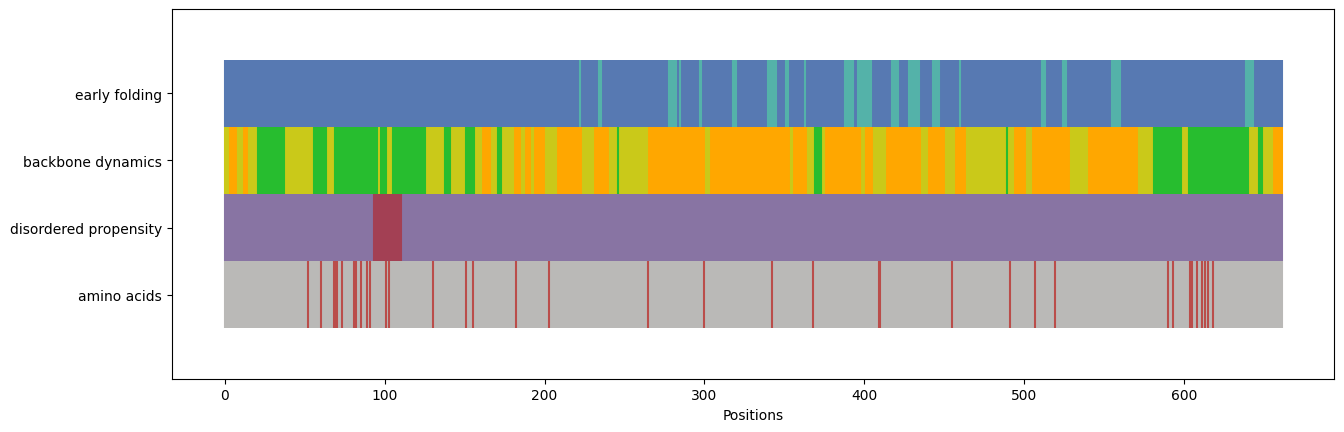

In [23]:
import matplotlib.pyplot as plt

# plot:
fig, ax = plt.subplots()
fig.set_figwidth(15)

x_len = len(biophysical_features_target_protein['seq'])

# Phospho

xs = [0.5]
vs = [[i for i, r in enumerate(biophysical_features_target_protein['seq']) if biophysical_features_target_protein['psites'][i] == 0]]
ax.eventplot(vs, orientation="horizontal", lineoffsets=xs, color='#bab9b7', linelengths=1) # unphosphorylated

xs = [0.5]
vs = [[i for i, r in enumerate(biophysical_features_target_protein['seq']) if biophysical_features_target_protein['psites'][i] == 1]]
ax.eventplot(vs, orientation="horizontal", lineoffsets=xs, color='#ba4d4a', linelengths=1) # phosphorylated

# Disorder

xs = [1.5]
vs = [[i for i, r in enumerate(biophysical_features_target_protein['seq']) if biophysical_features_target_protein['DO_label'][i] == 0]]
ax.eventplot(vs, orientation="horizontal", lineoffsets=xs, color='#8874a3', linelengths=1) # Ordered
 
xs = [1.5]
vs = [[i for i, r in enumerate(biophysical_features_target_protein['seq']) if biophysical_features_target_protein['DO_label'][i] == 1]]
ax.eventplot(vs, orientation="horizontal", lineoffsets=xs, color='#a34054', linelengths=1) # Disorder

# Backbone dynamics 

xs = [2.5]
vs = [[i for i, r in enumerate(biophysical_features_target_protein['seq']) if biophysical_features_target_protein['BD_label'][i] == 1]]
ax.eventplot(vs, orientation="horizontal", lineoffsets=xs, color='#cac919', linelengths=1) # membrane spanning 

xs = [2.5]
vs = [[i for i, r in enumerate(biophysical_features_target_protein['seq']) if biophysical_features_target_protein['BD_label'][i] == 2]]
ax.eventplot(vs, orientation="horizontal", lineoffsets=xs, color='#ffa700', linelengths=1) # rigid

xs = [2.5]
vs = [[i for i, r in enumerate(biophysical_features_target_protein['seq']) if biophysical_features_target_protein['BD_label'][i] == 3]]
ax.eventplot(vs, orientation="horizontal", lineoffsets=xs, color='#cac919', linelengths=1) # context dependent

xs = [2.5]
vs = [[i for i, r in enumerate(biophysical_features_target_protein['seq']) if biophysical_features_target_protein['BD_label'][i] == 4]]
ax.eventplot(vs, orientation="horizontal", lineoffsets=xs, color='#27bd2f', linelengths=1) # flexible


# Early folding

xs = [3.5]
vs = [[i for i, r in enumerate(biophysical_features_target_protein['seq']) if biophysical_features_target_protein['EF_label'][i] == 0]]
ax.eventplot(vs, orientation="horizontal", lineoffsets=xs, color='#5779b2', linelengths=1) # early folding

xs = [3.5]
vs = [[i for i, r in enumerate(biophysical_features_target_protein['seq']) if biophysical_features_target_protein['EF_label'][i] == 1]]
ax.eventplot(vs, orientation="horizontal", lineoffsets=xs, color='#54b2a9', linelengths=1) # non-early folding

ax.set(
    xlim=(0, x_len),
    ylim=(0, 4), yticks=[0.5, 1.5, 2.5, 3.5]
)

ax.set_xlabel('Positions')
ax.set_yticklabels(['amino acids', 'disordered propensity', 'backbone dynamics', 'early folding'])
ax.minorticks_off()
ax.autoscale()
plt.show()